# Add dates to pages

In [1]:
import pandas as pd
import arrow
import re
from IPython.display import display, HTML
import altair as alt

In [2]:
df_series = pd.read_csv('series_list.csv')[:-1]
all_holidays = pd.read_csv('nsw_holidays_1900_1950.csv')
#all_holidays.loc[:, 'date'] = pd.to_datetime(all_holidays.loc[:, 'date'], errors='coerce')

def get_holidays(year):
    holidays = all_holidays.loc[all_holidays['year'] == year]['date']
    return holidays.to_list()

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date.shift(days=+n)

In [3]:
missing = {
    '1901-01-07': 3,
    '1901-01-18': 4,
    '1901-01-23': 0, # Death of the Queen business abandoned https://trove.nla.gov.au/newspaper/article/14371864/1343690
    '1901-02-25': 4,
    '1901-03-18': 0,
    '1901-03-29': 0, # missing
    '1901-04-04': 3, # No afternoon, day before Easter
    '1901-04-09': 0, # Extra Easter Tuesday
    '1901-04-10': 0, # Extra Easter Wednesday
    '1901-05-27': 0, # Holiday Duke of Cornwall visiting
    '1901-05-28': 0, # Holiday Duke of Cornwall visiting
    '1901-07-03': 0, # Holiday for polling day
    '1901-09-16': 4, # No morning
    '1901-10-10': 4, # 1 Noon
    '1901-10-30': 4, # 1 Noon
    '1901-12-16': 2, # Noon only
    '1902-02-26': 0, # ??
    '1902-04-02': 3, # No afternboon
    '1902-06-26': 0, # ??
    '1902-08-09': 0, #??
    '1902-10-17': 6, # 008_0063 is a duplicate 
    '1903-01-06': 4, # 1 afternoon missing
    '1903-01-09': 4, # morning missing
    '1903-04-09': 3, # No afternoon, day before Easter
    '1903-04-14': 0, # Easter Tuesday
    # 1903-09-02 has no morning, but 3 noons
    '1903-09-08': 4, # no morning
    # 1903-09-16 has no morning, but 3 noons
    '1903-10-01': 3, # no afternoon
    '1903-11-18': 3, # no morning, 1 noon -- see 219 and 220!
    '1903-11-30': 7, # 2 sheets from 1903-11-18 inserted
    '1903-12-16': 0, # ??
    '1904-01-20': 3, # no afternoon
    '1904-08-15': 3, # no afternoon
    '1904-11-09': 6, # 016_145 is a duplicate
    '1905-03-02': 6, # 017_213 is a duplicate
    '1905-03-08': 6, # 017_239 is a duplicate
    '1905-04-20': 3, # No afternoon, day before Easter
    '1905-04-25': 0, # Easter Tuesday
    '1905-04-26': 0, # Easter Wednesday
    '1906-03-19': 6, # extra page, 282 is from 1906-03-21
    '1906-03-21': 4, # 1 page included in 1906-03-19
    '1906-04-02': 4, # 1 afternoon missing
    '1906-04-06': 4, # 1 afternoon missing
    '1906-04-09': 4, # 1 afternoon missing
    '1906-04-10': 4, # 1 afternoon missing
    '1906-04-11': 4, # 1 afternoon missing
    '1906-04-12': 3, # No afternoon, day before Easter
    '1906-04-17': 0, # Easter Tuesday
    '1906-04-18': 0, # Easter Wednesday
    '1906-04-25': 4, # 1 afternoon missing
    '1906-05-02': 4, # 1 afternoon missing
    '1906-05-03': 4, # 1 afternoon missing
    '1906-07-12': 4, # 1 afternoon missing
    '1906-07-16': 4, # 1 afternoon missing
    '1906-10-25': 3, # Afternoon missing
    '1907-02-02': 1, # Saturday 1 page only
    '1907-03-08': 4, # 1 afternoon missing
    '1907-04-29': 4, # 1 afternoon missing
    '1907-06-27': 2, # 2 pages only marked '11 o'clock'
    '1907-09-10': 3, # No afternoon
    '1907-10-11': 4, # 1 afternoon missing
    '1907-11-29': 4, # 1 afternoon missing
    '1907-12-02': 4, # 1 afternoon missing
    '1908-03-12': 4, # 1 afternoon missing
    '1908-04-16': 3, # No afternoon, day before Easter
    '1908-04-21': 0, # Easter Tuesday
    '1908-08-20': 0, # American Fleet visit!
    '1908-08-21': 3, # No morning?
    '1908-08-24': 0, # American Fleet visit!
    '1908-11-14': 1, # Saturday 1 page only
    '1929-03-01': 4,
    '1929-03-12': 3,
    '1929-03-27': 3,
    '1930-02-26': 3,
    '1930-04-17': 3,
    '1930-04-22': 0,
    '1930-04-23': 0,
    '1930-04-24': 0,
    '1930-04-26': 0,
    '1930-05-09': 3,
    '1930-12-23': 3
}

duplicates = [
    '008_0063',
    '016_145',
    '017_213',
    '119_265'
]

backwards = [
    '120'
]

In [4]:
pages_per_vol = {
    '1_134': {
        'weekday': 5,
        'saturday': 2
    },
    '135_145': {
        'weekday': 6,
        'saturday': 2
    },
    '146_164': {
        'weekday': 9,
        'saturday': 3
    },
    '165_190': {
        'weekday': 6,
        'saturday': 3
    },
    '191_199': {
        'weekday': 6,
        'saturday': 0
    },
}

def get_pages(vol_num):
    for key, pages in pages_per_vol.items():
        vols = key.split('_')
        vols = [int(y) for y in vols]
        if len(vols) == 2:
            vols = list(range(vols[0], vols[1] + 1))
        if vol_num in vols:
            return pages

In [5]:
def calculate_date(image_name, start_date, end_date, holidays, weekday_pages, saturday_pages):
    page_num = re.search(r'N193\-\d+_(\d+)', image_name).group(1)
    pages = 0
    for single_date in daterange(start_date, end_date):
        if single_date.format('YYYY-MM-DD') in missing:
            skip = missing[single_date.format('YYYY-MM-DD')]
        elif single_date.weekday() == 6 or single_date.format('YYYY-MM-DD') in holidays:
            skip = 0
        elif single_date.weekday() == 5:
            skip = 2
        else:
            skip = 5
        for s in range(1, skip + 1):
            pages += 1
            if pages == int(page_num):
                return single_date
            
def calculate_single_date(image_name):
    '''
    Get the date of a single page.
    '''
    vol_num, page_num = re.search(r'(N193\-\d+)_(\d+)', image_name).groups()
    # df_series = pd.read_csv('series_list.csv').dropna(subset=['Item_number'])
    volume = df_series.loc[df_series['Item_number'].str.contains(vol_num)].iloc[0]
    start_date = arrow.get(volume['start_date'], 'YYYY-MM-DD')
    end_date = arrow.get(volume['end_date'], 'YYYY-MM-DD').shift(days=+1)
    year = start_date.year
    holidays = sorted(get_holidays(year))
    single_date = calculate_date(image_name, start_date, end_date, holidays)
    return single_date

def save_dates(year):
    '''
    Assign dates to pages from a year.
    '''
    page_dates = []
    df = pd.read_csv(f'{year}.csv')
    # df_series = pd.read_csv('series_list.csv').dropna(subset=['Item_number'])
    volumes = list(df['referenceCode'].unique())
    holidays = get_holidays(year)
    for vol_ref, rows in df.groupby(by='referenceCode'):
        vol_num = int(vol_ref.split('-')[-1])
        vol_pages = get_pages(vol_num)
        volume = df_series.loc[df_series['Item_number'].str.contains(vol_ref)].iloc[0]
        start_date = arrow.get(volume['start_date'], 'YYYY-MM-DD')
        end_date = arrow.get(volume['end_date'], 'YYYY-MM-DD').shift(days=+1)
        for row in rows.itertuples():
            page_date = calculate_date(row.name, start_date, end_date, holidays, vol_pages['weekday'], vol_pages['saturday'])
            page_dates.append({'name': row.name, 'page_date': page_date.format('YYYY-MM-DD')})
    df_new = pd.merge(df, pd.DataFrame(page_dates), on='name')
    return df_new


In [6]:
df_new = save_dates(1901)

In [7]:
df_new.head()

directory               name  \
0  AU NBAC N193-001/  N193-001_0001.tif   
1  AU NBAC N193-001/  N193-001_0002.tif   
2  AU NBAC N193-001/  N193-001_0003.tif   
3  AU NBAC N193-001/  N193-001_0004.tif   
4  AU NBAC N193-001/  N193-001_0005.tif   

                                                path referenceCode  \
0  Shared/ANU-Library/Sydney Stock Exchange 1901-...      N193-001   
1  Shared/ANU-Library/Sydney Stock Exchange 1901-...      N193-001   
2  Shared/ANU-Library/Sydney Stock Exchange 1901-...      N193-001   
3  Shared/ANU-Library/Sydney Stock Exchange 1901-...      N193-001   
4  Shared/ANU-Library/Sydney Stock Exchange 1901-...      N193-001   

    startDate     endDate  year  width  height  columns column_positions  \
0  1901-01-01  1901-03-01  1901   6237    5000        3      0,1811,3222   
1  1901-01-01  1901-03-01  1901   6266    5000        3    205,1840,3259   
2  1901-01-01  1901-03-01  1901   6237    5000        2         286,2068   
3  1901-01-01  1901-03-01  1901   6236    5000        3      9,1821,3219   
4  1901-01-01  1901-03-01  1901   6236    5000        3    288,1821,3220   

    page_date  
0  1901-01-07  
1  1901-01-07  
2  1901-01-07  
3  1901-01-08  
4  1901-01-08

In [8]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def make_year_chart(df, year):
    df.loc[:, 'page_date'] = pd.to_datetime(df.loc[:, 'page_date'], errors='coerce')
    df.loc[:, 'week'] = df.loc[:, 'page_date'].apply(week_of_month)

    chart = alt.Chart(df).mark_rect(stroke='white').encode(
        x=alt.X('day(page_date):O', title='day'),
        y='week:O',
        facet=alt.Facet('month(page_date):T', title=''),
        color=alt.Color('count():Q', scale=alt.Scale(scheme='greenblue')),
        tooltip=['page_date:T', 'count():Q']
    ).properties(columns=4, title=str(year))
    
    return chart

In [9]:
def display_years(years=list(range(1901, 1909))):
    all_charts = alt.vconcat()
    for year in years:
        df = save_dates(year)
        all_charts &= make_year_chart(df, year)
    display(all_charts)

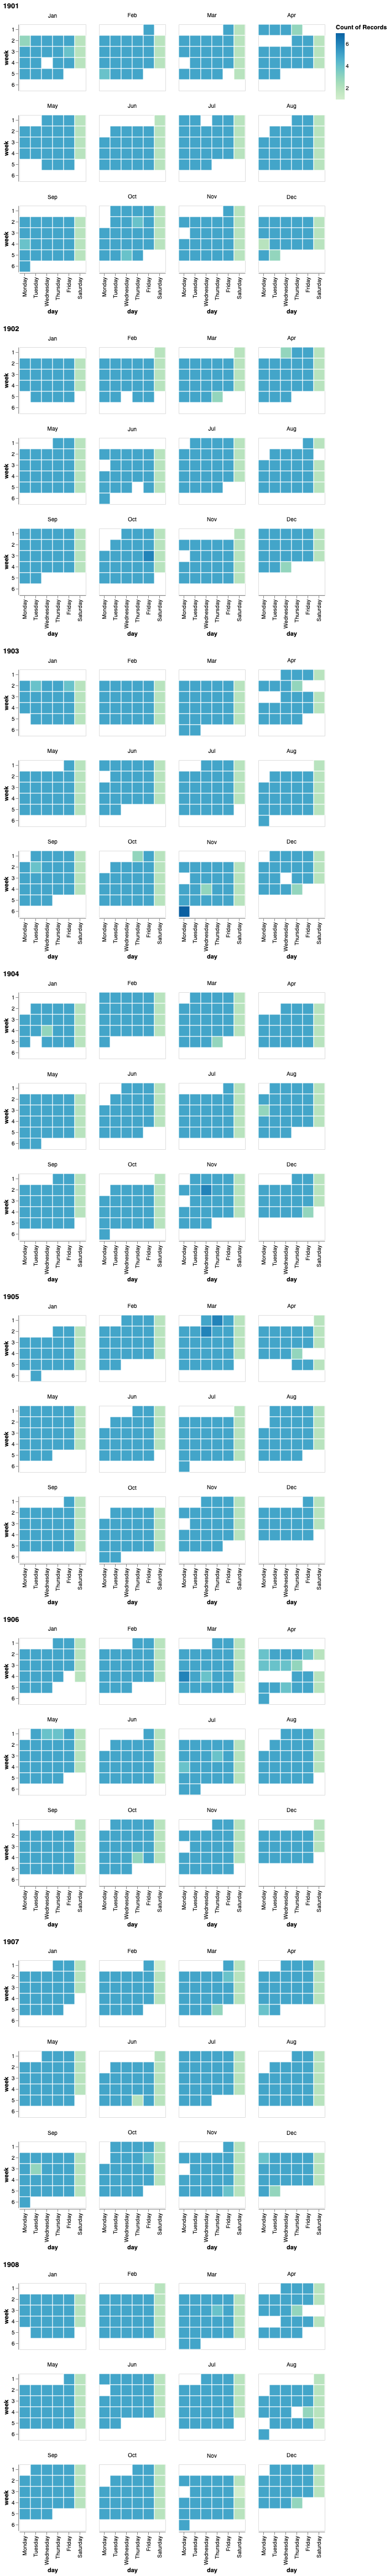

In [10]:
display_years()

In [11]:
def save_years(years=list(range(1901, 1909))):
    for year in years:
        df = save_dates(year)
        df.to_csv(f'{year}_with_dates.csv')

In [12]:
save_years()